In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [51]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import pickle
import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Flatten, Dense, AvgPool2D

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Generating Samples

In [7]:
from ood_detection_helper import *

model = load_model(inlier_name="brain", checkpoint=-1, filters=64,
                   save_path="/home/Developer/NCSN-TF2.0/saved_models/",
                   split="100,0"
                  )

(1, 91, 109, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 91, 109, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 91, 109, 64)  640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 91, 109, 64)  77696       conv2d[0][0]                     
                                                                 idx_sigmas[0]

In [17]:
SIGMAS = utils.get_sigma_levels().numpy()
SPLITS = utils.dict_splits["seg_brain"]
SPLITS

(1, 7)

In [44]:
def load_outlier_data(age="1year"):
    
    DATA_DIR = "/home/Developer/anodetect/data/test/"
    test_paths = glob.glob(DATA_DIR+"/"+age+"/*")
    
    # Create a dictionary describing the features.
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'segmentation': tf.io.FixedLenFeature([], tf.string),
    }

    @tf.function
    def _parse_record(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        return tf.io.parse_single_example(example_proto, image_feature_description)

    @tf.function
    def _parse_mri(example_proto):
        
        # Get the record and put it into a feature dict
        image_features = _parse_record(example_proto)
        
        # Deserialize the mri array 
        mri = tf.io.parse_tensor(image_features['image'],
                                out_type=tf.float32)
        return tf.expand_dims(mri, axis=-1)

    test  = tf.data.TFRecordDataset(test_paths).map(_parse_mri)

    return test, len(test_paths)

> ### Note that since we do not have masks, background values are not exactly zero
> ### Use an eps instead (default: 1e-10)

In [123]:
# Test Samples in ABCD
min_size = 900
x_outliers = []
outlier_datasets = []
ages = ["1year", "2year", "4year", "6year"]
for age in ages[0:]:
    x_outlier, test_size = load_outlier_data(age)
    print(age, test_size)
    
    x_outlier = x_outlier.batch(256)
    outlier_datasets.append(x_outlier)

# print("Min Sample Size:", min_size)

1year 756
2year 582
4year 519
6year 570


In [124]:
a=next(iter(outlier_datasets[0]))
a.shape

TensorShape([256, 91, 109, 1])

In [125]:
@tf.function
def remove_segs(x):
    x, segs = tf.split(x, SPLITS, axis=-1)
    return x

x_train, x_test =  get_train_test_data("seg_brain")
x_test = x_test.map(remove_segs)
# x_test = x_test.batch(TEST_BATCH).take(BATCH_COUNT).cache()
x_test = x_test.batch(256)

x_train = x_train.map(remove_segs)
x_train = x_train.batch(256)

inlier_batch = next(iter(x_test))
inlier_batch.shape

Split: ['train', 'test']


TensorShape([256, 91, 109, 1])

In [126]:
%%time
train_dist = compute_scores(model, x_train)
train_norms = weighted_norm(train_dist)

Sigma: 0.0100: 100%|██████████| 10/10 [14:16<00:00, 85.70s/it]

CPU times: user 6min 25s, sys: 6min 16s, total: 12min 41s
Wall time: 14min 16s


In [127]:
%%time
inlier_dist = compute_scores(model, x_test)
inlier_norms = weighted_norm(inlier_dist)
inlier_norms.shape

Sigma: 0.0100: 100%|██████████| 10/10 [01:34<00:00,  9.41s/it]

CPU times: user 33.5 s, sys: 26.7 s, total: 1min
Wall time: 1min 34s


TensorShape([1137, 10])

In [128]:
%%time
outlier_dists = [compute_scores(model, ood) for ood in outlier_datasets]
outlier_norms = [weighted_norm(scores) for scores in outlier_dists]

Sigma: 0.0100: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]

CPU times: user 1min 9s, sys: 55.9 s, total: 2min 5s
Wall time: 3min 22s


In [129]:
score_dict = {"train":train_norms.numpy(), "test":inlier_norms.numpy()}
for name, ood in zip(ages, outlier_norms):
    score_dict[name] = ood.numpy()
score_dict.keys()

dict_keys(['train', 'test', '1year', '2year', '4year', '6year'])

In [130]:
with open("brain_scores.p", "wb") as f:
    pickle.dump(score_dict, f)

In [131]:
LABELS = ["Train", "Inlier"] + ages

In [132]:
X_train, X_test =  score_dict["train"].copy(), score_dict["test"].copy()
outlier_scores = [score_dict[name] for name in ages]

In [133]:
year1 = next(iter(outlier_datasets[0])).numpy()

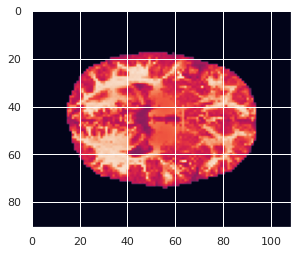

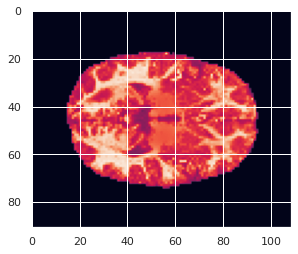

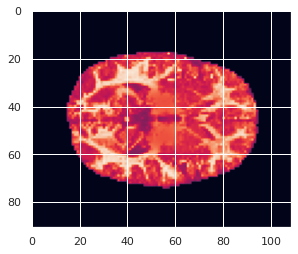

In [134]:
for i in range(3):
    plt.imshow(year1[i,...,-1])
    plt.show()

## GMM

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  31 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   37.7s finished


Best: 2.904938 using {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
---------------------------------------------------------------------------
1.185903 (1.591341) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.092024 (1.594029) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.622531 (0.514235) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.775395 (0.505570) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.839218 (0.514747) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.893829 (0.491678) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.896099 (0.568187) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.904938 (0.518782) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.570024 (1.591557) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.495070 (1.826058) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
CPU times

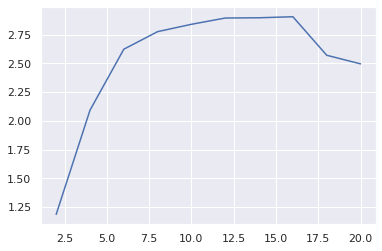

In [135]:
%%time
best_gmm_clf = train_gmm(X_train, verbose=True)

In [136]:
print("---Likelihoods---")
print("Training: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{}: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))

for name, ood in zip(LABELS[2:], outlier_scores):
    print("{}: {:.3f}".format(name, best_gmm_clf.score(ood)))

---Likelihoods---
Training: 3.217
Inlier: 1.292
1year: -18.639
2year: -16.218
4year: -11.646
6year: -8.983


In [137]:
%%time
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
ood_scores = [best_gmm_clf.score_samples(ood) for ood in outlier_scores]

CPU times: user 1.06 s, sys: 2.28 s, total: 3.35 s
Wall time: 86.8 ms


# OOD Evaluation

In [138]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

Inlier vs 1year
----------------
ROC-AUC: 99.9087
PR-AUC (In/Out): 99.8458 / 99.9459
FPR (95% TPR): 0.53%
Detection Error: 0.79%

Inlier vs 2year
----------------
ROC-AUC: 99.6884
PR-AUC (In/Out): 99.3898 / 99.8425
FPR (95% TPR): 0.97%
Detection Error: 1.40%

Inlier vs 4year
----------------
ROC-AUC: 95.0222
PR-AUC (In/Out): 92.2761 / 97.1978
FPR (95% TPR): 30.26%
Detection Error: 11.24%

Inlier vs 6year
----------------
ROC-AUC: 93.6731
PR-AUC (In/Out): 90.6094 / 95.8488
FPR (95% TPR): 41.34%
Detection Error: 12.25%



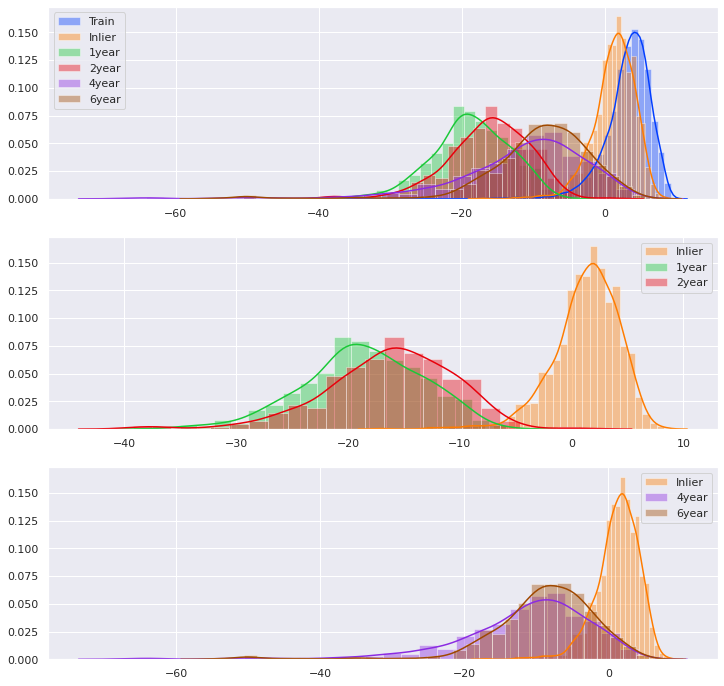

In [139]:
evaluate_model(train_score, test_score, ood_scores, labels=LABELS)

# Validation Check

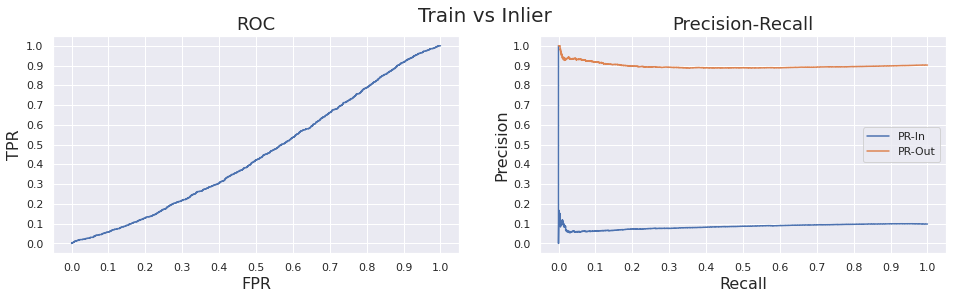

Train vs Inlier
----------------
ROC-AUC: 45.3590
PR-AUC (In/Out): 8.4756 / 89.7992
FPR (95% TPR): 92.95%
Detection Error: 48.96%


{'roc_auc': 0.4535902332788877,
 'fpr_tpr95': 0.9295238095238095,
 'fpr_tpr80': 0.8081904761904762,
 'pr_auc_in': 0.0847557962344021,
 'pr_auc_out': 0.8979918474692513,
 'ap': 0.0850678133512504,
 'de': 0.4896460610629476}

In [99]:
ood_metrics(-train_score, -test_score, names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

## KD Tree

In [105]:
from sklearn.neighbors import NearestNeighbors
N_NEIGHBOURS = 10

In [111]:
%%time
nbrs = NearestNeighbors(n_neighbors=N_NEIGHBOURS, algorithm='kd_tree').fit(X_train)

train_distances, indices = nbrs.kneighbors(X_train)

CPU times: user 2.23 s, sys: 35.3 ms, total: 2.27 s
Wall time: 2.26 s


In [112]:
ood_dists = {}
test_distances, _ = nbrs.kneighbors(X_test)

for name, ood in zip(ages, outlier_scores):
    dists, _ = nbrs.kneighbors(ood)
    ood_dists[name] = dists 

 vs k=1
----------------
ROC-AUC: 96.7967
PR-AUC (In/Out): 96.1761 / 97.2477
FPR (95% TPR): 20.40%
Detection Error: 7.97%

 vs k=4
----------------
ROC-AUC: 97.7447
PR-AUC (In/Out): 97.1257 / 98.2617
FPR (95% TPR): 9.50%
Detection Error: 6.30%

 vs k=7
----------------
ROC-AUC: 97.8093
PR-AUC (In/Out): 97.0964 / 98.3968
FPR (95% TPR): 8.80%
Detection Error: 6.63%

 vs k=10
----------------
ROC-AUC: 97.7958
PR-AUC (In/Out): 97.0952 / 98.3517
FPR (95% TPR): 8.53%
Detection Error: 6.25%



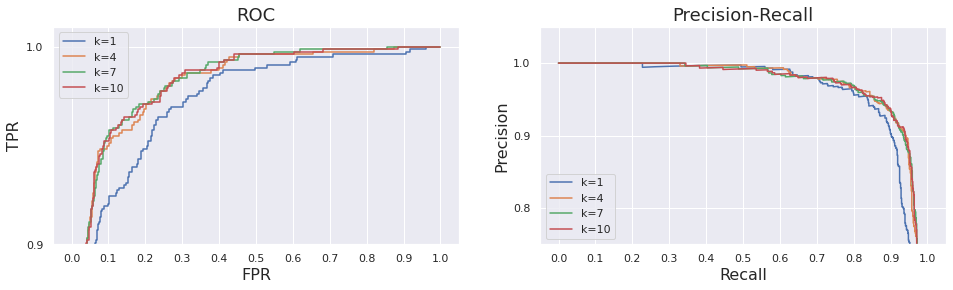

In [113]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
ticks = np.arange(0.0, 1.1, step=0.1)

for k in range(0,N_NEIGHBOURS,3):
    inlier_score = test_distances[:, k]
    outlier_score = ood_dists["1year"][:, k]
    
    ood_metrics(inlier_score,outlier_score, names=("", "k={}".format(k+1)), plot=False, verbose=True)
    print()
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                                 np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, drop_intermediate=True)
    prec_in, rec_in, _ = precision_recall_curve(y_true, y_scores)
    _label = "k={:d}".format(k+1)
    
    axs[0].plot(fpr, tpr, label=_label)
    axs[1].plot(rec_in, prec_in, label=_label)
    
    
    
axs[0].set(
    xlabel="FPR", ylabel="TPR", title="ROC", ylim=(0.9, 1.01),
    xticks=ticks, yticks=ticks
)
axs[0].legend()

axs[1].set(
        xlabel="Recall", ylabel="Precision", title="Precision-Recall", ylim=(0.75, 1.05),
        xticks=ticks, yticks=ticks
)
axs[1].legend()
# fig.suptitle("{} vs {}".format(*names), fontsize=20)
plt.show()
plt.close()

In [114]:
for name, dists in ood_dists.items():
    ood_metrics(test_distances[:,-1], dists[:,-1], names=("Inlier", name), plot=False, verbose=True)
    print()

Inlier vs 1year
----------------
ROC-AUC: 97.7958
PR-AUC (In/Out): 97.0952 / 98.3517
FPR (95% TPR): 8.53%
Detection Error: 6.25%

Inlier vs 2year
----------------
ROC-AUC: 92.0804
PR-AUC (In/Out): 86.6778 / 95.0685
FPR (95% TPR): 32.28%
Detection Error: 15.49%

Inlier vs 4year
----------------
ROC-AUC: 96.2732
PR-AUC (In/Out): 94.1538 / 97.8645
FPR (95% TPR): 21.90%
Detection Error: 8.60%

Inlier vs 6year
----------------
ROC-AUC: 94.8732
PR-AUC (In/Out): 92.1617 / 96.8963
FPR (95% TPR): 24.10%
Detection Error: 11.72%

